### Visualization: Passes
<h5>Notebook Brief:</h5>

In this notebook, I attempt to visualize and get insights out of passes data of the World Cup 2022. 

<h5>Workflow (Steps):</h5>

- Dembele's two footdness
- Pass network
- Where players receives (heatmap)

Imports 

In [8]:
from statsbombpy import sb
import pandas as pd
import numpy as np

import seaborn as sn 
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager, VerticalPitch


import warnings
warnings.filterwarnings('ignore')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')

In [2]:
df_comps=  sb.competitions()

# Get competition and season ids 
df_comps[(df_comps.competition_name== 'FIFA World Cup') & (df_comps.season_name== '2022')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,106,International,FIFA World Cup,male,False,True,2022,2023-02-03T13:22:36.184520,2023-01-26T11:23:27.631134,2023-01-26T11:23:27.631134,2023-02-03T13:22:36.184520


In [3]:
grouped_events = sb.competition_events(
    country="International",
    division= "FIFA World Cup",
    season="2022",
    split=True
)

In [4]:
passes_df= grouped_events["passes"]
passes_df.head(2)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,counterpress,pass_cross,pass_deflected,pass_cut_back,pass_outswinging,pass_miscommunication,pass_inswinging,pass_goal_assist,out,pass_straight
0,dd7183e3-e7ab-47d4-9035-5e827f351c88,5,1,00:00:00.812,0,0,Pass,2,Netherlands,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ac155851-e1ff-421f-8e93-f197b8020239,9,1,00:00:02.747,0,2,Pass,2,Netherlands,From Kick Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Dembele's two footdness plot 

In [5]:
# Split location column into start_X and start_Y columns
passes_df[['start_X', 'start_Y']] = pd.DataFrame(passes_df['location'].to_list(), index= passes_df.index)
passes_df[['end_X', 'end_Y']]= pd.DataFrame(passes_df['pass_end_location'].to_list(), index= passes_df.index)

# Filter passes
passes_df= passes_df.loc[passes_df.play_pattern.isin(['Regular Play', 'From Counter', 'From Free Kick'])]
ousmane_df= passes_df.loc[(passes_df.player== 'Ousmane Dembélé') & 
                          (passes_df.pass_body_part.isin(('Right Foot', 'Left Foot')))]
ousmane_df

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,pass_outswinging,pass_miscommunication,pass_inswinging,pass_goal_assist,out,pass_straight,start_X,start_Y,end_X,end_Y
6299,9dac35d3-5302-4e55-8c1e-559dfa14d864,254,1,00:06:01.447,6,1,Pass,16,France,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,64.6,76.1,44.1,71.4
6307,a7505965-30e2-401c-9ce7-e3c6cacc800c,278,1,00:06:33.099,6,33,Pass,16,France,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,52.2,66.7,45.8,60.5
6356,f8703392-f8e5-446e-a151-0ca99ab2418f,453,1,00:12:58.738,12,58,Pass,22,France,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,90.3,66.3,93.3,19.2
6374,ce7dc5a4-d8e4-47cc-b1b2-28bfa3f86999,509,1,00:14:32.354,14,32,Pass,24,France,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,89.5,75.9,80.0,74.4
6480,4a8eb20a-f868-40df-90d2-22b3b870161b,852,1,00:25:31.101,25,31,Pass,39,Argentina,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,80.3,70.8,88.8,56.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54916,3180489a-03a0-4582-bf73-139ebced44a2,3093,2,00:40:10.808,85,10,Pass,163,France,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,55.8,70.4,56.6,66.4
54938,f97661a5-8ad0-42d9-9039-d36139373b5a,3170,2,00:42:39.974,87,39,Pass,168,France,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,103.8,58.4,94.4,27.6
54973,598b4111-6d54-4b1b-8f60-6a1d5d7cc074,3288,2,00:45:54.268,90,54,Pass,173,France,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,70.6,61.2,58.8,54.4
54998,5c805a87-2234-40df-872d-dd553b250ba4,3383,2,00:49:07.452,94,7,Pass,177,France,From Free Kick,...,NaN,NaN,NaN,NaN,NaN,NaN,101.9,70.6,108.8,34.6


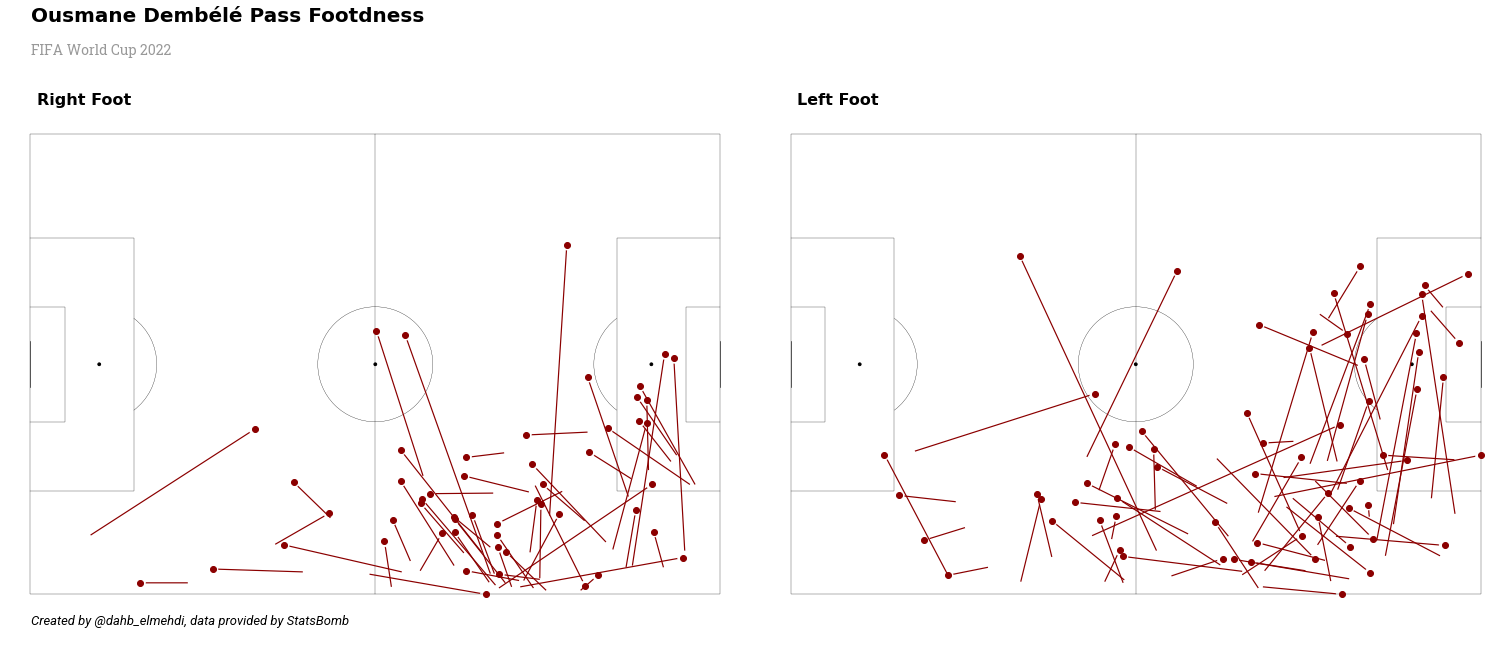

In [6]:
# Set pitches
pitch = Pitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)

X= list(ousmane_df.start_X)
Y= list(ousmane_df.start_Y)
end_X= list(ousmane_df.end_X)
end_Y= list(ousmane_df.end_Y)
foot= list(ousmane_df.pass_body_part)


for i in range(len(X)):
    if foot[i]=='Right Foot':
        ax['pitch'][0].scatter(end_X[i], end_Y[i],color="#8B0000")
        pitch.arrows(X[i], Y[i], end_X[i], end_Y[i], color = "#8B0000", width=1.2, headwidth= 0, ax=ax['pitch'][0])
    else:
        ax['pitch'][1].scatter(end_X[i], end_Y[i],color="#8B0000")
        pitch.arrows(X[i], Y[i], end_X[i], end_Y[i], color = "#8B0000", width=1.2, headwidth= 0, ax=ax['pitch'][1])

ax['pitch'][0].set_title(label="Right Foot", loc='left',x= .04, fontweight='bold', fontsize= 16)
ax['pitch'][1].set_title(label="Left Foot", loc='left',x= .04, fontweight='bold', fontsize= 16)


# Set titles
def set_titles(fig, title, subtitle, description):
    fig.text(0.04, .97, title, fontsize=20, fontweight= 'bold', color='black')
    fig.text(0.04, .92, subtitle, fontsize=14, color='black',fontproperties= font_bold.prop,alpha=.4)
    fig.text(0.04, .04, description, fontsize=13, color='black',fontproperties= font_italic.prop)

title_text= "Ousmane Dembélé Pass Footdness"
subtitle= "FIFA World Cup 2022"
Description= 'Created by @dahb_elmehdi, data provided by StatsBomb'
set_titles(fig, title_text, subtitle, Description)

# Save the graph
fig.savefig("../Plots/passes-1.png", dpi= 150, bbox_inches='tight')

2. Passing network

To create a pass network, we must first gather information about player positioning and amount of passes. These details can be summarized as follows:
- Average player locations 
- Number of passes between players
- Color and fifth line are determined by the number of connections and passes made by participants.

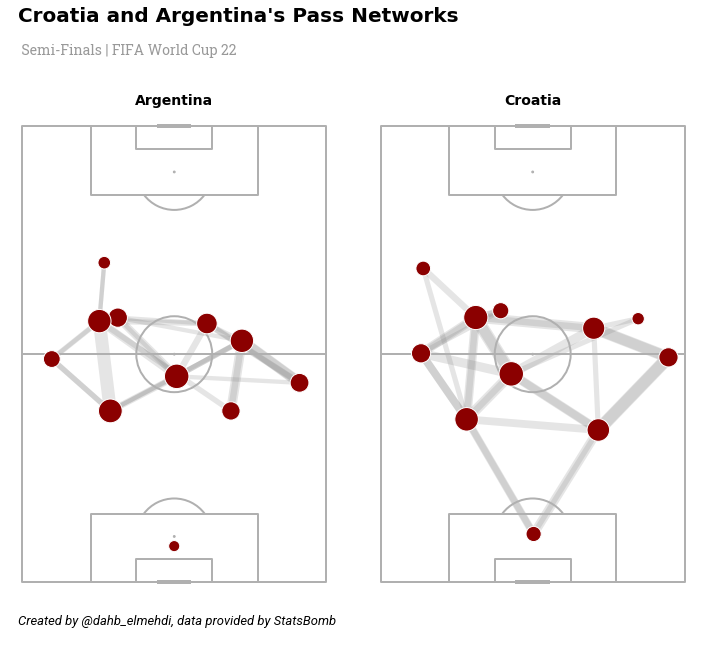

In [9]:
# First let's import events data of the World Cup final
df= sb.matches(competition_id=43, season_id=106)
final_id= int(df.loc[
    (df.competition_stage== 'Semi-finals') &
    ((df.home_team== 'Argentina') | (df.away_team== 'Argentina'))
               ].match_id.values)

events = sb.events(match_id=final_id)

pitch = VerticalPitch(half=False)
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White")    

for team in enumerate(events.team.unique()):   
    first_sub= events.loc[(events.type== 'Substitution') & (events.team== team[1])].minute.min()
    DF= events.loc[(~events.pass_outcome.isin(['Out', 'Incomplete', 'Unknown', 'Pass Offside'])) & (events.team== team[1] ) &
                  (events.type=='Pass') & (events.minute< first_sub)]

    DF[['start_X', 'start_Y']] = pd.DataFrame(DF['location'].to_list(), index= DF.index)
    DF[['end_X', 'end_Y']]= pd.DataFrame(DF['pass_end_location'].to_list(), index= DF.index)

    # Average locations 
    avg_locations= DF.groupby('player').agg({'start_X':['mean', 'count'], 'start_Y': 'mean'})
    #Rename columns
    avg_locations.columns= ['X','count', 'Y']

    # Numbers of passses btween players
    pass_between= DF.groupby(['player', 'pass_recipient']).id.count().reset_index()
    pass_between.rename({'id': 'number_of_passes'}, axis=1, inplace=True)

    # Merge the 2 dataframes to get average location starting and ending location of passes
    pass_between= pass_between.merge(avg_locations, on='player')
    pass_between= pass_between.merge(avg_locations, left_on='pass_recipient', right_index=True, suffixes=['', '_end'])
    pass_between= pass_between.loc[pass_between.number_of_passes> 3]
    pass_between.head()

    # Calculate the line width and marker sizes relative to the largest counts
    max_line_width= 13
    max_marker_size = 600
    pass_between['width']= pass_between.number_of_passes / pass_between.number_of_passes.max() * max_line_width
    avg_locations['marker_size']= (avg_locations['count'] / avg_locations['count'].max() * max_marker_size)

    # Set color to make the lines more transparent when fewer passes are made
    min_transparency= 0.3
    color= np.array(to_rgba('white'))
    color= np.tile(color, (len(pass_between), 1))
    c_transparency= pass_between.number_of_passes / pass_between.number_of_passes.max()
    c_transparency= (c_transparency * (1 - min_transparency)) + min_transparency
    color[:, 3]= c_transparency

    pass_between= pass_between.loc[pass_between.number_of_passes> 2]
    
    # Plotting
    pitch.lines(pass_between.X, pass_between.Y,
                            pass_between.X_end, pass_between.Y_end, lw=pass_between.width,
                            color='Grey', zorder=.1, ax=ax['pitch'][team[0]], alpha= .2)
    pitch.scatter(avg_locations.X, avg_locations.Y, s= avg_locations.marker_size, 
                               color='#8B0000', linewidth=1,edgecolor= 'white',alpha=1, ax=ax['pitch'][team[0]])
    # Set titles
    ax['pitch'][team[0]].set_title(label='{}'.format(team[1]), loc='center', fontweight='bold', fontsize= 14)

# set titles
title= "Croatia and Argentina's Pass Networks"
subtitle= " Semi-Finals | FIFA World Cup 22"
set_titles(fig, title, subtitle, Description)

# Save graph
fig.savefig("../Plots/passes-2.png", dpi= 150, bbox_inches='tight')

3. A heatmap displaying where African national teams strikers received the ball.



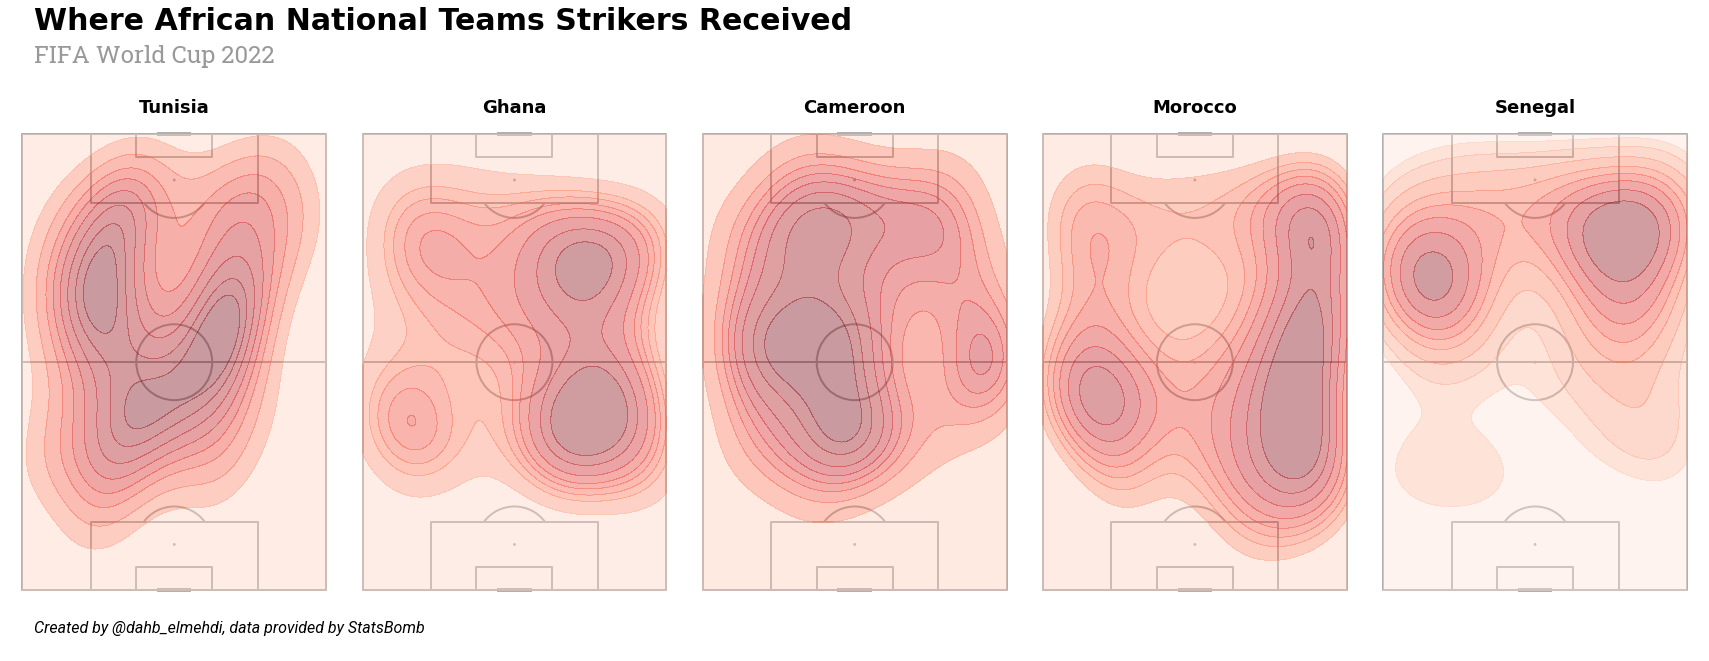

In [91]:
# African teams and strikers positions
african_teams= ['Tunisia', 'Ghana', 'Cameroon','Morocco', 'Senegal']
ST_positions= ['Center Forward', 'Left Wing', 'Right Wing', 'Left Center Forward', 'Right Center Forward']

# Filter data
passes_df= passes_df.loc[(~passes_df.pass_outcome.isin(['Out', 'Incomplete', 'Unknown', 'Pass Offside'])) &
                         (passes_df.team.isin(african_teams)) & (passes_df.position.isin(ST_positions))]

# Set up pitches 
pitch = VerticalPitch(half=False)
fig, ax= pitch.grid(ncols= 5, grid_height= .75, space= .05, axis= False)
fig.set_facecolor("White") 

# Plotting 
import seaborn as sns
cmap = sns.cubehelix_palette(start=15, light=1, as_cmap=True)
for team in enumerate(african_teams):
    X= passes_df.loc[passes_df.team== team[1]].end_X.to_list()
    Y= passes_df.loc[passes_df.team== team[1]].end_Y.to_list()
    kde = pitch.kdeplot(X, Y, ax=ax['pitch'][team[0]], fill=True, shade_lowest=True, cmap="Reds", color="#8B0000", alpha=.4)
    ax['pitch'][team[0]].set_title(label='{}'.format(team[1]), loc='center', fontweight='bold', fontsize= 18)

# Set titles
title= "Where African National Teams Strikers Received"
subtitle= "FIFA World Cup 2022"
fig.text(0.04, .97, title, fontsize=30, fontweight= 'bold', color='black')
fig.text(0.04, .92, subtitle, fontsize=24, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.04, .04, Description, fontsize=16, color='black',fontproperties= font_italic.prop)

# Save graph
fig.savefig("../Plots/passes-3.png", dpi= 150, bbox_inches='tight')